In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import function as f
import re
import os

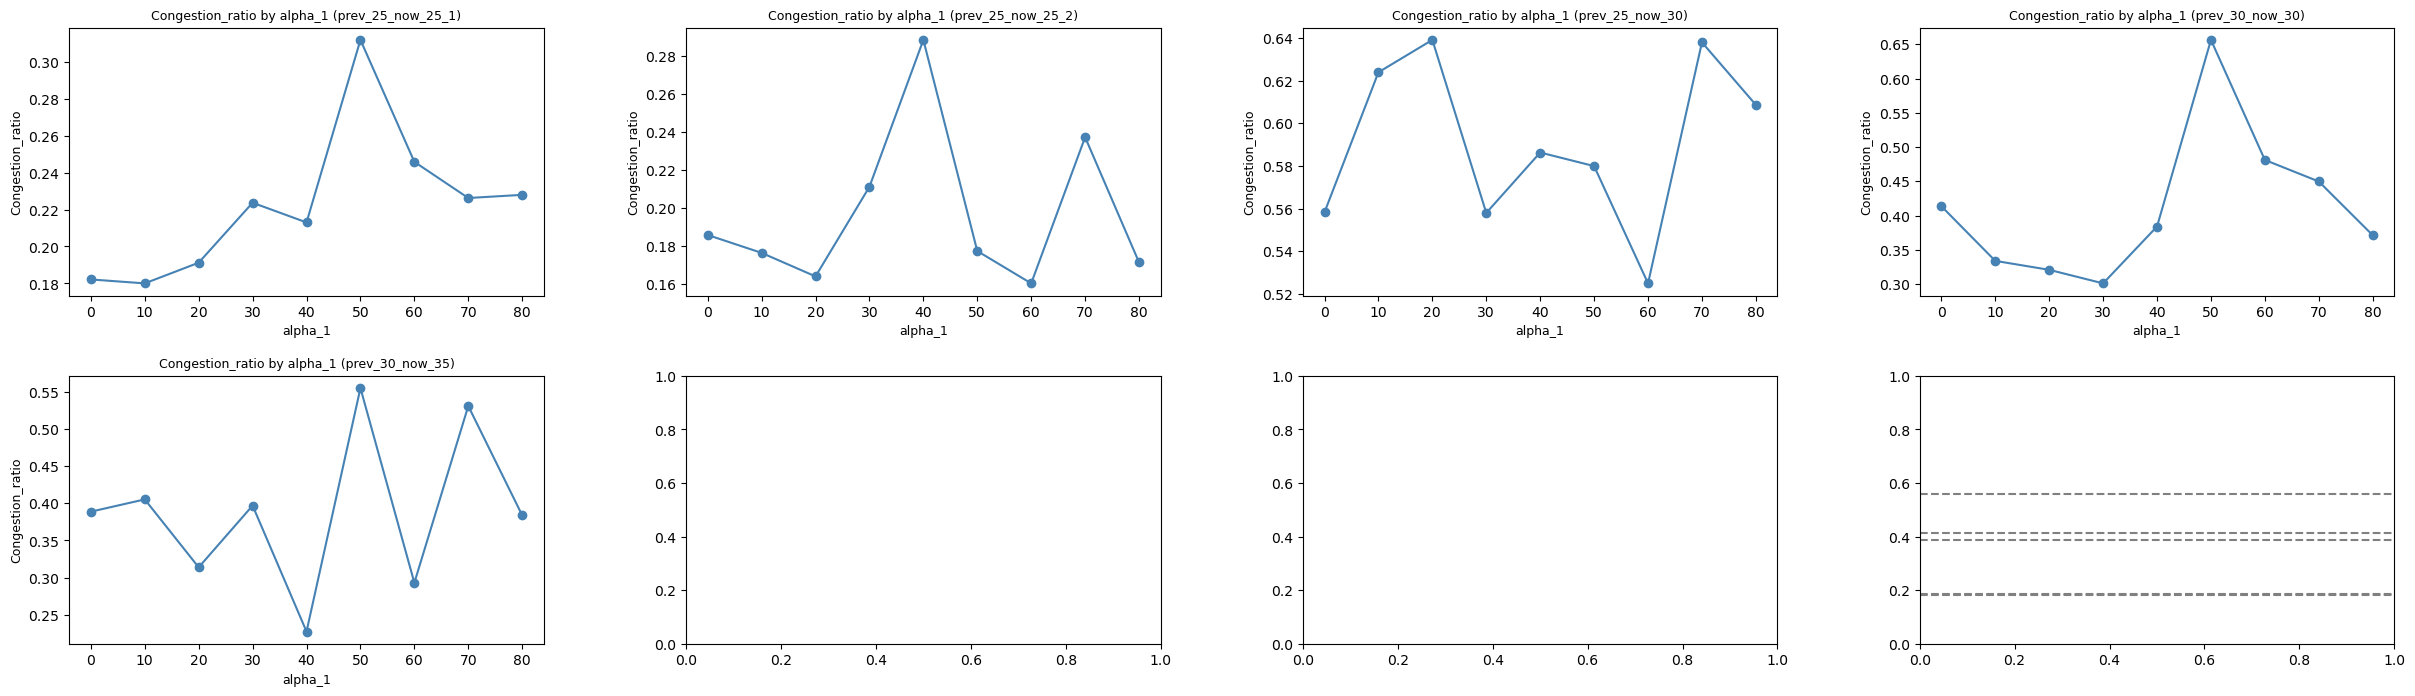

In [27]:
directory_path = '../Simulation/Assets/Results/Congestion'
x_label = 'alpha_1'
y_label = 'Congestion_ratio'
title = 'Congestion_ratio by alpha_1'
row_num = 2
col_num = 4
f.Create_subplot_congestion(directory_path, x_label, y_label, title, row_num, col_num, (30, 8))